In [1]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

[ Info: Oceananigans will use 4 threads


In [20]:
@inline function quscatterplot(runname, i=nothing)
    foldername = "../scratch/filament-instability/$runname"
    qRifilename = "qRi.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    function ω²ᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        let u = (circshift(uᶠᶜᶜ, (-1, 0)) .+ uᶠᶜᶜ) ./ 2,
            w = (wᶜᶜᶠ[:, 1:end-1] .+ wᶜᶜᶠ[:, 2:end]) ./ 2
            u.^2 .+ w.^2
            #∂xw = (circshift(w, (-1, 0)) - circshift(w, (1, 0))) ./ (2Δx),
            #∂zu = (u - circshift(u, (0, 1))) ./ Δzᵃᵃᶜ
            #∂zu[:, 1] .= ∂zu[:, 2]
            #(∂zu - ∂xw).^2
        end
    end
    function qᶜᶜᶜ(vᶜᶠᶜ, bᶜᶜᶜ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        ∂xbᶜᶜᶜ = (circshift(bᶜᶜᶜ, (-1, 0)) - circshift(bᶜᶜᶜ, (1, 0))) ./ (2Δx)
        ∂xvᶜᶠᶜ = (circshift(vᶜᶠᶜ, (-1, 0)) - circshift(vᶜᶠᶜ, (1, 0))) ./ (2Δx)
        
        ∂zbᶜᶜᶜ = (bᶜᶜᶜ - circshift(bᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zbᶜᶜᶜ[:, 1] .= ∂zbᶜᶜᶜ[:, 2]
        
        ∂zvᶜᶠᶜ = (vᶜᶠᶜ - circshift(vᶜᶠᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zvᶜᶠᶜ[:, 1] .= ∂zvᶜᶠᶜ[:, 2]
        return (∂xvᶜᶠᶜ .+ 1) .* ∂zbᶜᶜᶜ .- ∂zvᶜᶠᶜ .* ∂xbᶜᶜᶜ
    end
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    file = jldopen("$foldername/$filename")
    #qRifile = jldopen("$foldername/$qRifilename")

    n = Observable(101)

    frame = @lift frames[$n]
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    
    σ=0
    v = @lift imfilter(file["timeseries/v_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
    u = @lift imfilter(file["timeseries/u_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
    w = @lift imfilter(file["timeseries/w_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
    b = @lift imfilter(file["timeseries/b_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
    
    # Get the secondary cirulation streamfunction
    uₛ = @lift sqrt.(ω²ᶜᶜᶜ($u, $w, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)[:, zᵃᵃᶜ.>-0.1][:])
    
    q = @lift qᶜᶜᶜ($v, $b, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)[:, zᵃᵃᶜ.>-0.1][:]
    
    title = @lift "Ro=$(round(sp.Ro; digits=1)), Ri=$(round(sp.Ri; digits=1)), Ek=$(round(sp.Ek; digits=1)), t = $(round(ts[$n]; digits=2))"

    axis_kwargs = (; xlabel=L"q", ylabel=L"|u|", title, limits=(-20, 20, 0, 0.05))

    fig = Figure(resolution=(800, 800))
    ax = Axis(fig[1, 1]; axis_kwargs...)
    
    scatter!(ax, q, uₛ ; marker=:+, markersize=2)
    if i != nothing
        n[] = i
        return fig
    end
    
    vidfoldername = "output/videos/$runname/quscatterplot"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig; resolution=(1000, 1000))
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    #rm("$vidfoldername.zip")
    fig
end

quscatterplot (generic function with 2 methods)

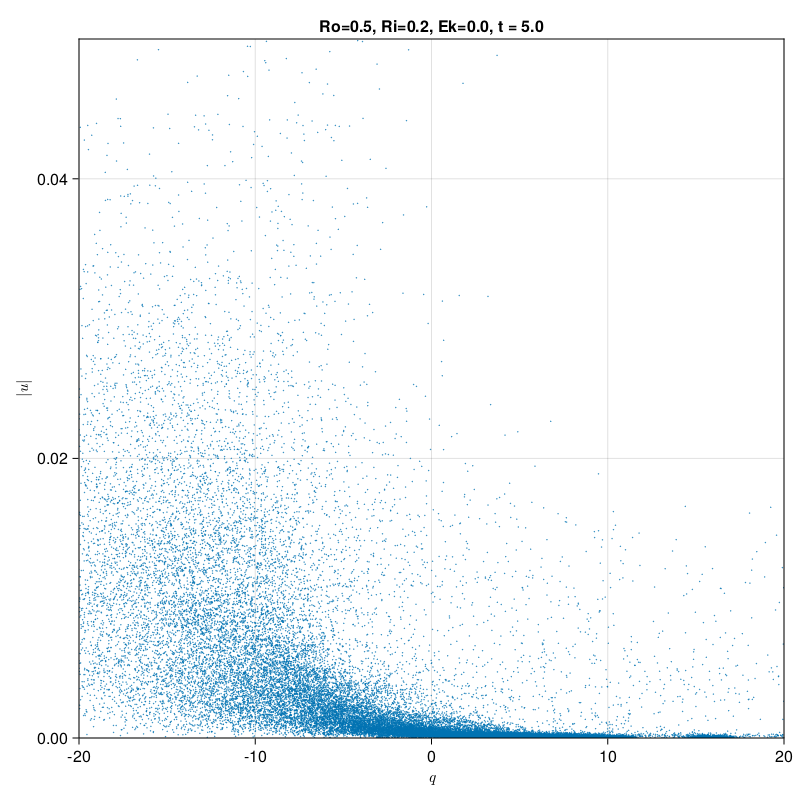

In [21]:
quscatterplot("Ro05Ri02Ek0", 601)

In [82]:
@inline function ω_by_pv_sign(runname)
    foldername = "../scratch/filament-instability/$runname"
    qRifilename = "qRi.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    function u²ᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        let u = (circshift(uᶠᶜᶜ, (-1, 0)) .+ uᶠᶜᶜ) ./ 2,
            w = (wᶜᶜᶠ[:, 1:end-1] .+ wᶜᶜᶠ[:, 2:end]) ./ 2,
            ∂xw = (circshift(w, (-1, 0)) - circshift(w, (1, 0))) ./ (2Δx),
            ∂zu = (u - circshift(u, (0, 1))) ./ Δzᵃᵃᶜ
            ∂zu[:, 1] .= ∂zu[:, 2]
            (∂zu - ∂xw).^2
        end
    end
    function qᶜᶜᶜ(vᶜᶠᶜ, bᶜᶜᶜ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        ∂xbᶜᶜᶜ = (circshift(bᶜᶜᶜ, (-1, 0)) - circshift(bᶜᶜᶜ, (1, 0))) ./ (2Δx)
        ∂xvᶜᶠᶜ = (circshift(vᶜᶠᶜ, (-1, 0)) - circshift(vᶜᶠᶜ, (1, 0))) ./ (2Δx)
        
        ∂zbᶜᶜᶜ = (bᶜᶜᶜ - circshift(bᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zbᶜᶜᶜ[:, 1] .= ∂zbᶜᶜᶜ[:, 2]
        
        ∂zvᶜᶠᶜ = (vᶜᶠᶜ - circshift(vᶜᶠᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zvᶜᶠᶜ[:, 1] .= ∂zvᶜᶠᶜ[:, 2]
        return (∂xvᶜᶠᶜ .+ 1) .* ∂zbᶜᶜᶜ .- ∂zvᶜᶠᶜ .* ∂xbᶜᶜᶜ
    end
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    
    file = jldopen("$foldername/$filename")
    out = map(frames) do frame
        σ=0
        v = imfilter(file["timeseries/v_dfm/$frame"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
        u = imfilter(file["timeseries/u_dfm/$frame"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
        w = imfilter(file["timeseries/w_dfm/$frame"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
        b = imfilter(file["timeseries/b_dfm/$frame"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
        
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        uₛ = ω²ᶜᶜᶜ(u, w, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ) .* Δzᵃᵃᶜ * Δx
        q = qᶜᶜᶜ(v, b, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ) .* Δzᵃᵃᶜ * Δx
        uₛ = uₛ[:, zᵃᵃᶜ .>= -0.1]
        q = q[:, zᵃᵃᶜ .>= -0.1]
        [sqrt(sum(uₛ[q .< 0])), sqrt(sum(uₛ[q .>= 0]))]
    end
    
    u_neg = [a[1] for a in out]
    u_pos = [a[2] for a in out]
    return (u_neg, u_pos)
end

ω_by_pv_sign (generic function with 1 method)

In [83]:
(u_neg, u_pos) = ω_by_pv_sign("Ro05Ri02Ek0");